In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [18]:
import sys
import os

from pathlib import Path
p = Path(os.getcwd()).parents[1]
sys.path.append(p.__str__())

from src import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json
import math

sns.set_style("darkgrid")
sns.set_context("paper")

In [5]:
BASE_DIR = "../../experiments/sin2-models-64"

In [29]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

#profiles = ["0layer-64-s05", "1layer-64-s05", "2layer-64-s05", "4layer-64-s05", "7layer-64-s05", "10layer-64-s05"]
profiles = ["0layer-64-sl", "1layer-64-sl", "2layer-64-sl", "4layer-64-sl", "7layer-64-sl", "10layer-64-sl"]
names = [configs[p]["NAME"] for p in profiles]

In [30]:
configs.keys()

KeysView(<configparser.ConfigParser object at 0x7f0ca2fef6d0>)

In [31]:
train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/train_stats.json", "r") as f:
        train_stats[name] = json.load(f)[0]

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/results.json", "r") as f:
        results[name] = json.load(f)[0]

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    # Load posterior samples
    train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_1.npy")
    test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_1.npy")
    test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_1.npy")
    test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_1.npy")

    posterior_samples[name] = {
        "train": train,
        "test": test,
        "test_in_domain": test_in_domain,
        "test_out_domain": test_out_domain
    }

In [48]:
#Generate table of results
table = pd.DataFrame(columns=["Name", "Train RMSE", "Test RMSE", "Test RMSE in domain", "Test RMSE out domain"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train RMSE": train_stats[name][""]["rmse"],
        "Test RMSE": results[name]["rmse"],
        "Test RMSE in domain": results[name]["rmse_in_domain"],
        "Test RMSE out domain": results[name]["rmse_out_domain"]
    }, ignore_index=True)

table

KeyError: 'rmse'

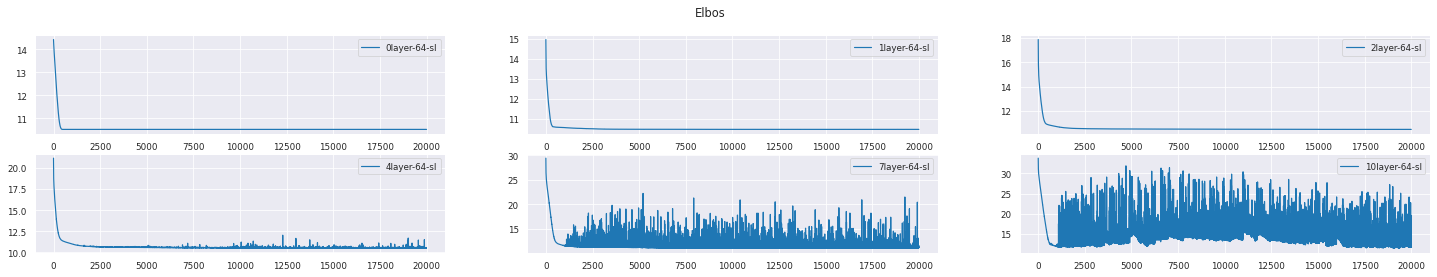

In [32]:
fig, ax = plt.subplots(2, 3, figsize=(25, 4))
fig.suptitle("Elbos")
ax = ax.flatten()
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    elbos = [math.log(x) for x in train_stats[name]["elbos"]]
    ax[i].plot(elbos, label=name)
    ax[i].legend()
plt.show()

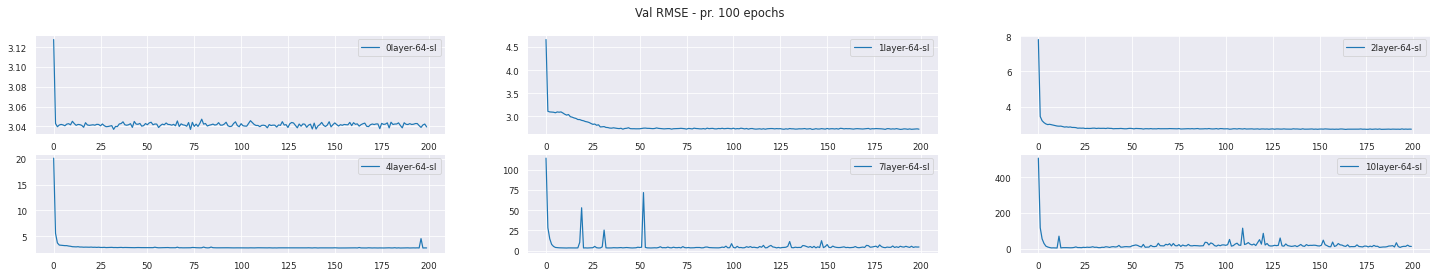

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(25, 4))
fig.suptitle("Val RMSE - pr. 100 epochs")
ax = ax.flatten()
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    rmse = train_stats[name]["rmse_epoch"]
    ax[i].plot(rmse, label=name)
    ax[i].legend()
plt.show()

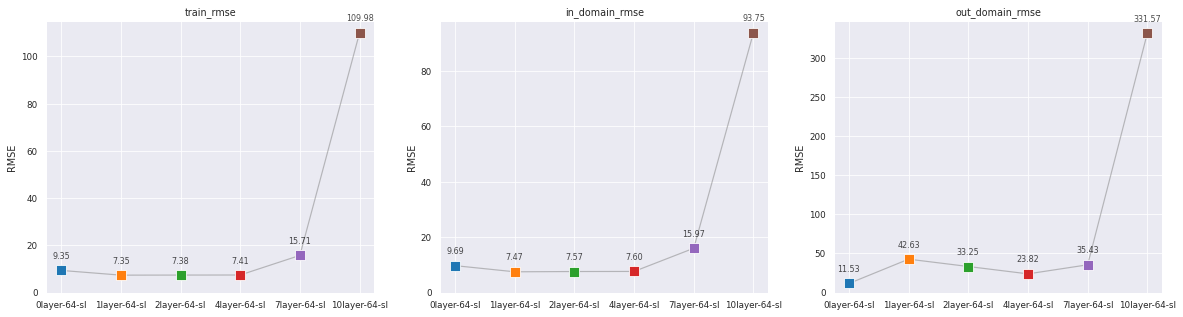

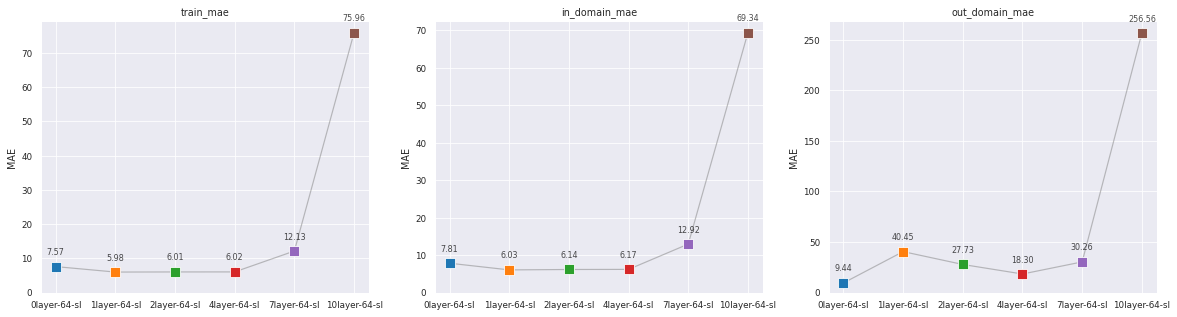

In [43]:
train_rmse = [results[k]["train"]["error"]["rmse"] for k in names]
in_domain_rmse = [results[k]["in_domain"]["error"]["rmse"] for k in names]
out_domain_rmse = [results[k]["out_domain"]["error"]["rmse"] for k in names]

metrics = [("train_rmse", train_rmse), ("in_domain_rmse", in_domain_rmse), ("out_domain_rmse", out_domain_rmse)]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

fig, ax = plt.subplots(1,3, figsize=(20,5))
ax = ax.flatten()
for i, (n, m) in enumerate(metrics):
    sns.scatterplot(
    x=names, y=m, marker="s", s=100,
    ax=ax[i], c=colors, alpha=1.0, zorder=10)
    sns.lineplot(
    x=names, y=m, ax=ax[i], color="gray", alpha=0.5)
    #annotate each point
    for x, y in zip(names, m):
        ax[i].annotate(
            f"{y:.2f}",
            xy=(x, y),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
            color="black",
            alpha=0.7,
        )
    ax[i].set_title(n)
    ax[i].set_ylabel("RMSE")
    ax[i].set_ylim(bottom=0.0)

plt.show()



train_mae = [results[k]["train"]["error"]["mae"] for k in names]
in_domain_mae = [results[k]["in_domain"]["error"]["mae"] for k in names]
out_domain_mae = [results[k]["out_domain"]["error"]["mae"] for k in names]

metrics = [("train_mae", train_mae), ("in_domain_mae", in_domain_mae), ("out_domain_mae", out_domain_mae)]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

fig, ax = plt.subplots(1,3, figsize=(20,5))
ax = ax.flatten()
for i, (n, m) in enumerate(metrics):
    sns.scatterplot(
    x=names, y=m, marker="s", s=100,
    ax=ax[i], c=colors, alpha=1.0, zorder=10)
    sns.lineplot(
    x=names, y=m, ax=ax[i], color="gray", alpha=0.5)
    for x, y in zip(names, m):
        ax[i].annotate(
            f"{y:.2f}",
            xy=(x, y),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
            color="black",
            alpha=0.7,
        )
    ax[i].set_title(n)
    ax[i].set_ylabel("MAE")
    ax[i].set_ylim(bottom=0.0)

plt.show()

In [44]:
name1 = configs[profiles[1]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}


In [45]:
print(data_samples["train_x"].shape)
print(data_samples["train_dist_samples"].shape)
print(posterior_samples[name1]["train"].shape)

(1000, 10)
(1000, 1000)
(1000, 1000)


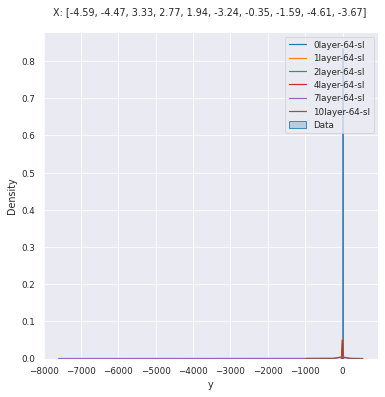

In [46]:

# Plot posterior samples
labels = [configs[p]["NAME"] for p in profiles]
x_samp = data_samples["train_x"][1]
train_samp = data_samples["train_dist_samples"][:, 1]
pred_train_samples = [posterior_samples[p]["train"][:, 1] for p in profiles]
plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, figsize=(6,6), x_sample=x_samp, title="Posterior samples - Train", save_path=f"{BASE_DIR}/results/posterior_comparison.png")

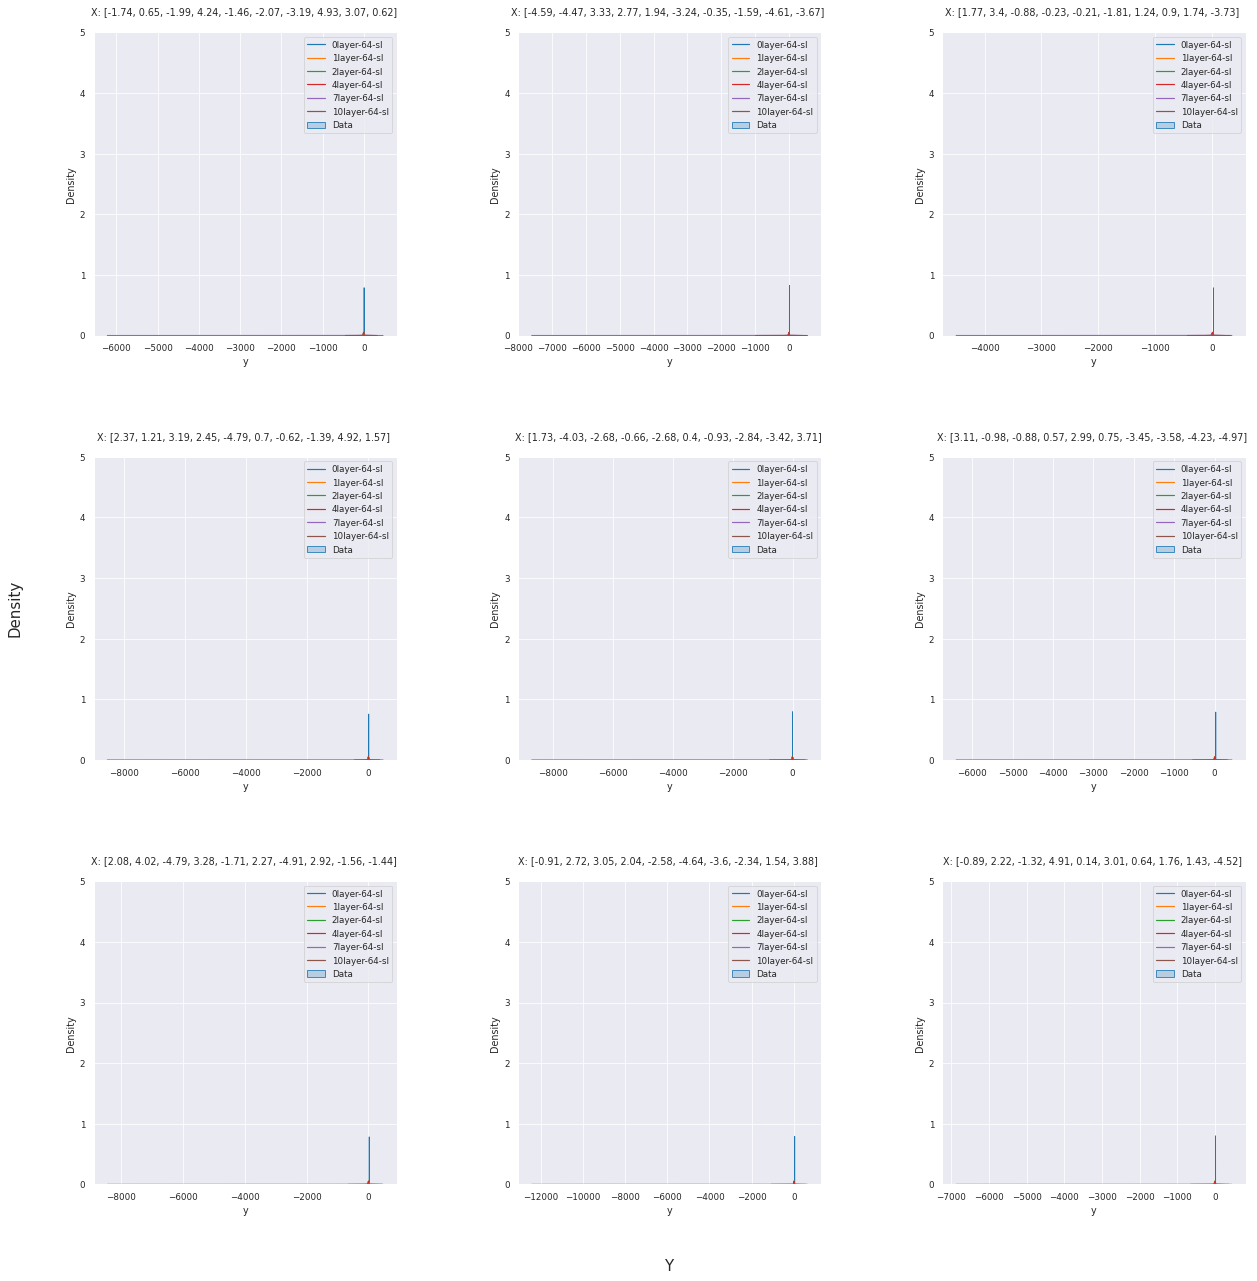

In [47]:
sns.set_style("darkgrid")
sns.set_context("paper")

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()
fig.tight_layout()
#fig.suptitle(title, fontsize=15)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)
fig.text(0.5, 0.04, 'Y', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i, ax in enumerate(axs):
    labels = [configs[p]["NAME"] for p in profiles]
    x_samp = data_samples["train_x"][i]
    train_samp = data_samples["train_dist_samples"][:, i]
    pred_train_samples = [posterior_samples[p]["train"][:, i] for p in profiles]
    plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, x_sample=x_samp, ax=ax)   
    ax.set_ylim([0, 5])

plt.show()